# Run simulation 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from array_to_df import using_multiindex


SKIP_SIMULATION = True



R_myopic = 1400  # Base reward for myopic solution
R_optimal = 2200  # Base reward for optimal solution
R_random = 600  # Base reward for random solutions
sigma = 200  # Standard deviation for Gaussian noise

In [71]:

def grid_dict(params):
    keys = list(params)
    grids = np.meshgrid(*[params[k] for k in keys], indexing="ij")
    flat = [g.ravel() for g in grids]
    return {k: v for k, v in zip(keys, flat)}

In [72]:


def individual_learning(q_opt, d_myopic, d_optimal, k):
    # effective number of trails
    k_opt = np.random.binomial(k, q_opt)
    k_myo = k - k_opt

    # print(k_opt)

    # probability of discovery
    d_opt_total = 1.0 - np.power(1.0 - d_optimal[:,np.newaxis], k_opt)
    d_myo_total = 1.0 - np.power(1.0 - d_myopic[:,np.newaxis], k_myo)

    # print(d_opt_total)

    u = np.random.rand(*q_opt.shape)
    discovered_optimal = (u < d_opt_total)
    discovered_myopic  = (~discovered_optimal) & (u < (d_opt_total + (1.0 - d_opt_total) * d_myo_total))

    # print(discovered_optimal)

    q_opt_post = np.zeros_like(q_opt)
    q_opt_post = np.where(discovered_myopic, 0, q_opt_post)
    q_opt_post = np.where(discovered_optimal, 1, q_opt_post)

    # print(q_opt_post)

    return q_opt_post

def demonstration(K_demonstration, epsilon, q_opt):
    n_non_random = np.random.binomial(K_demonstration, epsilon[:,np.newaxis])
    n_random = K_demonstration - n_non_random
    n_optimal = np.random.binomial(n_non_random, q_opt)
    n_myopic = n_non_random - n_optimal
    return n_random, n_optimal, n_myopic

def get_rewards(n_random, n_optimal, n_myopic):
    base_reward = n_random * R_random + n_optimal * R_optimal + n_myopic * R_myopic
    noise = np.random.normal(0, sigma, size=base_reward.shape)
    return base_reward + noise

def get_teacher_indices(prev_rewards, n_teacher):
    M = prev_rewards.shape[0]
    N_gen = prev_rewards.shape[1]
    teacher_indices = np.zeros((M, N_gen), dtype=int)
    for m in range(prev_rewards.shape[0]): # For each replication
        for n in range(prev_rewards.shape[1]): # For each agent
            random_k_possible_teacher = np.random.choice(N_gen, n_teacher[m], replace=False) # Randomly select K possible teachers
            teacher_indices_within_k = np.argmax(prev_rewards[m, random_k_possible_teacher]) # Select the teacher with the highest average reward
            teacher_indices[m, n] = random_k_possible_teacher[teacher_indices_within_k] # Retrieve the teacher's index
    return teacher_indices


def social_learning(n_opt_t, n_myo_t, n_normal_t, lambda_):
    M = n_opt_t.shape[0]
    N_gen = n_opt_t.shape[1]
    post_q_opt = (n_opt_t) / (n_opt_t + n_myo_t + n_normal_t)
    is_learned = (np.random.rand(M, N_gen) < lambda_[:,np.newaxis])
    post_q_opt = np.where(is_learned, post_q_opt, 0)
    return post_q_opt

def run_simulation(d, G, N_gen, N_mach, K_demo):
    M = len(d['replication'])
    is_machine = np.zeros((M, G, N_gen), dtype=bool)
    is_machine[d['condition'] == 'human-machine',0,:N_mach] = True

    print(is_machine.sum())

    K_ind = np.ones((M, G, N_gen), dtype=int) * d['K_human'][:,np.newaxis,np.newaxis]
    K_ind = np.where(is_machine, d['K_machine'][:,np.newaxis,np.newaxis], K_ind)

    q_opt = np.ones((M, G, N_gen)) * d['q_opt_human'][:,np.newaxis,np.newaxis]
    q_opt = np.where(is_machine, d['q_opt_machine'][:,np.newaxis,np.newaxis], q_opt)


    n_normal = np.empty((M, G, N_gen))
    n_optimal = np.empty((M, G, N_gen))
    n_myopic = np.empty((M, G, N_gen))

    rewards = np.empty((M, G, N_gen))

    cond = d['condition']
    d_optimal_log = d['d_optimal_log']
    d_opt = np.power(10, d_optimal_log)
    d_myo = d['d_myopic']
    n_t = d['n_teacher']
    l = d['lambda']
    e = d['epsilon']

    for g in range(G):
        # print("Individual learning")
        q_opt_ind = individual_learning(q_opt[:,g], d_myo, d_opt, K_ind[:,g])
        if g > 0:
            # print("Select teacher")
            teacher_indices = get_teacher_indices(rewards[:,g-1], n_t)
            m_idx = np.arange(M)[:,np.newaxis]
            # print(n_optimal[:,g-1])
            n_opt_t = n_optimal[m_idx, g-1, teacher_indices]
            n_myo_t = n_myopic[m_idx, g-1, teacher_indices]
            n_normal_t = n_normal[m_idx, g-1, teacher_indices]
            # print("Social learning")
            q_opt_social = social_learning(n_opt_t, n_myo_t, n_normal_t, l)
            q_opt_post = np.maximum(q_opt_ind, q_opt_social)
            # print(n_opt_t, n_myo_t, q_opt_social)
        else:
            q_opt_post = q_opt_ind
        # print("Demonstration")
        n_normal[:,g], n_optimal[:,g], n_myopic[:,g] = demonstration(K_demo, e, q_opt_post)
        rewards[:,g] = get_rewards(n_normal[:,g], n_optimal[:,g], n_myopic[:,g])

    rewards_df = using_multiindex(rewards, ['rep', 'gen', 'agent'], value_name='rewards')
    n_normal_df = using_multiindex(n_normal, ['rep', 'gen', 'agent'], value_name='other')
    n_optimal_df = using_multiindex(n_optimal, ['rep', 'gen', 'agent'], value_name='optimal')
    n_myopic_df = using_multiindex(n_myopic, ['rep', 'gen', 'agent'], value_name='myopic')


    meta_df = pd.DataFrame(d)
    meta_df['rep'] = np.arange(len(meta_df))

    df = meta_df.merge(rewards_df, on='rep')
    df = df.merge(n_normal_df, on=['rep', 'gen', 'agent'])
    df = df.merge(n_optimal_df, on=['rep', 'gen', 'agent'])
    df = df.merge(n_myopic_df, on=['rep', 'gen', 'agent'])
    df['discovered'] = (df.groupby(['rep', 'gen'])['optimal'].transform('sum') > 0)
    df['learnability difficulty'] = 1 - df['lambda']
    df['discoverability difficulty'] = -df['d_optimal_log']
    df['myopic bias'] = 1 - df['q_opt_human'] * 2
    df['myopic bias intensity'] = np.log((1 - df['q_opt_human']) / df['q_opt_human'])
    return df


In [73]:
# How does exploration horizon and bias discover rate of optimal solution

N_gen = 8  # Number of agents per generation
N_mach = 0  # Number of machines
G = 100
K_demo = 10

K_human = np.logspace(1, 4, 10, base=10, endpoint=True).astype(int)
K_machine = [0] # not used
# K_machine = K_human

q_opt_human = np.logspace(-8, -1, 8, base=2, endpoint=True)
q_opt_machine = [0] # not used
# q_opt_machine = q_opt_human


epsilon = [1] # Probability of non-random exploration
R = 20  # Number of replications of the simulation
n_teacher = [5] # Number of agents observed during social learning

d_myopic = [0.5]  # Discoverability rate for myopic solutions
d_optimal_log_ = np.linspace(0, -6, 10)
# d_optimal_log_ = [-4.]

lambda_ = [0.9]  # Social learning rate
conditions = ['human']


grid_d = {
    'condition': conditions,
    'd_myopic': d_myopic,
    'd_optimal_log': d_optimal_log_,
    'lambda': lambda_,
    'n_teacher': n_teacher,
    'replication': np.arange(R),
    'epsilon': epsilon,
    'q_opt_human': q_opt_human,
    'K_human': K_human,
    'K_machine': K_machine,
    'q_opt_machine': q_opt_machine,
}

d = grid_dict(grid_d)
if not SKIP_SIMULATION:
    df = run_simulation(d, G, N_gen, N_mach, K_demo)
    df_agg = df.groupby(['rep','replication', 'gen', 'K_human', 'discoverability difficulty', 'myopic bias intensity']).agg(
        {
            'discovered': 'max',
            'optimal': 'mean',
            'myopic': 'mean',
            'other': 'mean',
            'rewards': 'mean',
        }
    )
    df_agg.to_parquet('../data/abm_v2/bias_discoverability.parquet')

0


In [87]:
df_agg = pd.read_parquet('../data/abm_v2/bias_discoverability.parquet')

In [76]:
df_agg.reset_index()['rep'].nunique()

16000

/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_1016/3297227419.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_yticklabels(axs[3].get_yticklabels())  # keep colorbar tick labels


[]

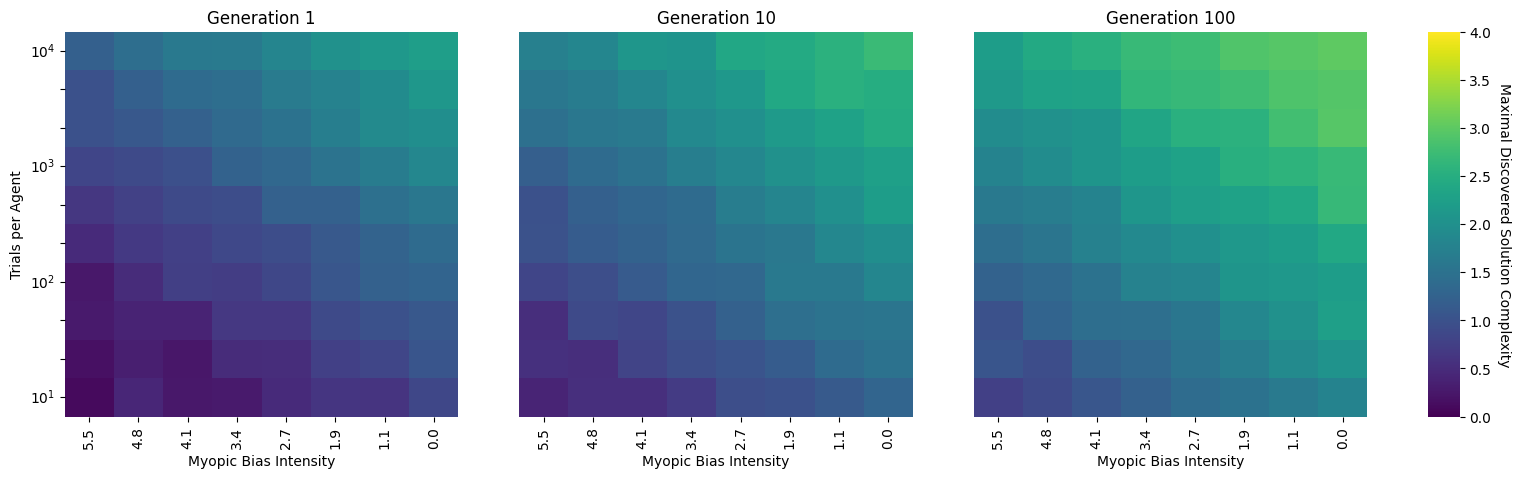

In [ ]:
max_discovered = df_agg[df_agg['discovered']].reset_index().groupby(['gen', 'K_human', 'myopic bias intensity', 'rep'])['discoverability difficulty'].max().reset_index()

m = max_discovered.reset_index().pivot_table(index=['gen', 'K_human'],
                               columns='myopic bias intensity', values='discoverability difficulty')

import matplotlib.pyplot as plt

m = m.sort_index(axis=0, ascending=False)
m = m.sort_index(axis=1, ascending=False)
# Three plots next to each other, plus a fourth axis for the shared colorbar
fig, axs = plt.subplots(1, 4, figsize=(18, 5), gridspec_kw={"width_ratios": [1, 1, 1, 0.08]})


hm = sns.heatmap(m.loc[0], ax=axs[0], cbar=False, cmap='viridis', vmin=0, vmax=4)
hm = sns.heatmap(m.loc[9], ax=axs[1], cbar=False, cmap='viridis', vmin=0, vmax=4)
hm = sns.heatmap(m.loc[99], ax=axs[2], cbar=False, cmap='viridis', vmin=0, vmax=4)

# Put the colorbar in its own (fourth) axis so all three heatmaps have equal size
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[3])
# Remove border around the colorbar
cbar.outline.set_visible(False)
# Set new label for the colorbar
cbar.ax.set_ylabel('Maximal Discovered Solution Complexity', rotation=-90, va="bottom")

axs[0].set_ylabel('Trials per Agent')
# Remove the y-axis labels for plot 2 and 3
axs[1].set_ylabel('')
axs[2].set_ylabel('')

axs[0].set_xlabel('Myopic Bias Intensity')
axs[1].set_xlabel('Myopic Bias Intensity')
axs[2].set_xlabel('Myopic Bias Intensity')


# Format the y-ticks (one significant digiEt)
yvals = m.loc[0].index.values
mask = np.isclose(np.log10(yvals) % 1, 0)
axs[0].set_yticklabels([rf"$10^{int(np.log10(v))}$" if m else '' for v,m in zip(yvals, mask)])

# Remove tick labels for plot 2 and 3
axs[1].set_yticks([])
axs[2].set_yticks([])

# Format the x-ticks (one significant digit)
tick_labels = [f"{x:.1f}" for x in m.columns]
# axs[0].set_xticks(rm1.columns)
axs[0].set_xticklabels(tick_labels)
# axs[1].set_xticks(rm1.columns)
axs[1].set_xticklabels(tick_labels)
# axs[2].set_xticks(rm1.columns)
axs[2].set_xticklabels(tick_labels)

axs[0].set_title('Generation 1')
axs[1].set_title('Generation 10')
axs[2].set_title('Generation 100')

# Hide ticks and labels on the colorbar axis except for the bar itself
axs[3].set_yticklabels(axs[3].get_yticklabels())  # keep colorbar tick labels
axs[3].set_xticks([])

/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_1016/4170698237.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = m.loc[(gen, dd_val)]
/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_1016/4170698237.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = m.loc[(gen, dd_val)]
/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_1016/4170698237.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = m.loc[(gen, dd_val)]
/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_1016/4170698237.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = m.loc[(gen, dd_val)]
/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_1016/4170698237.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = m.loc[(gen, dd_val)]
/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_1016/4170698237.py:21

[]

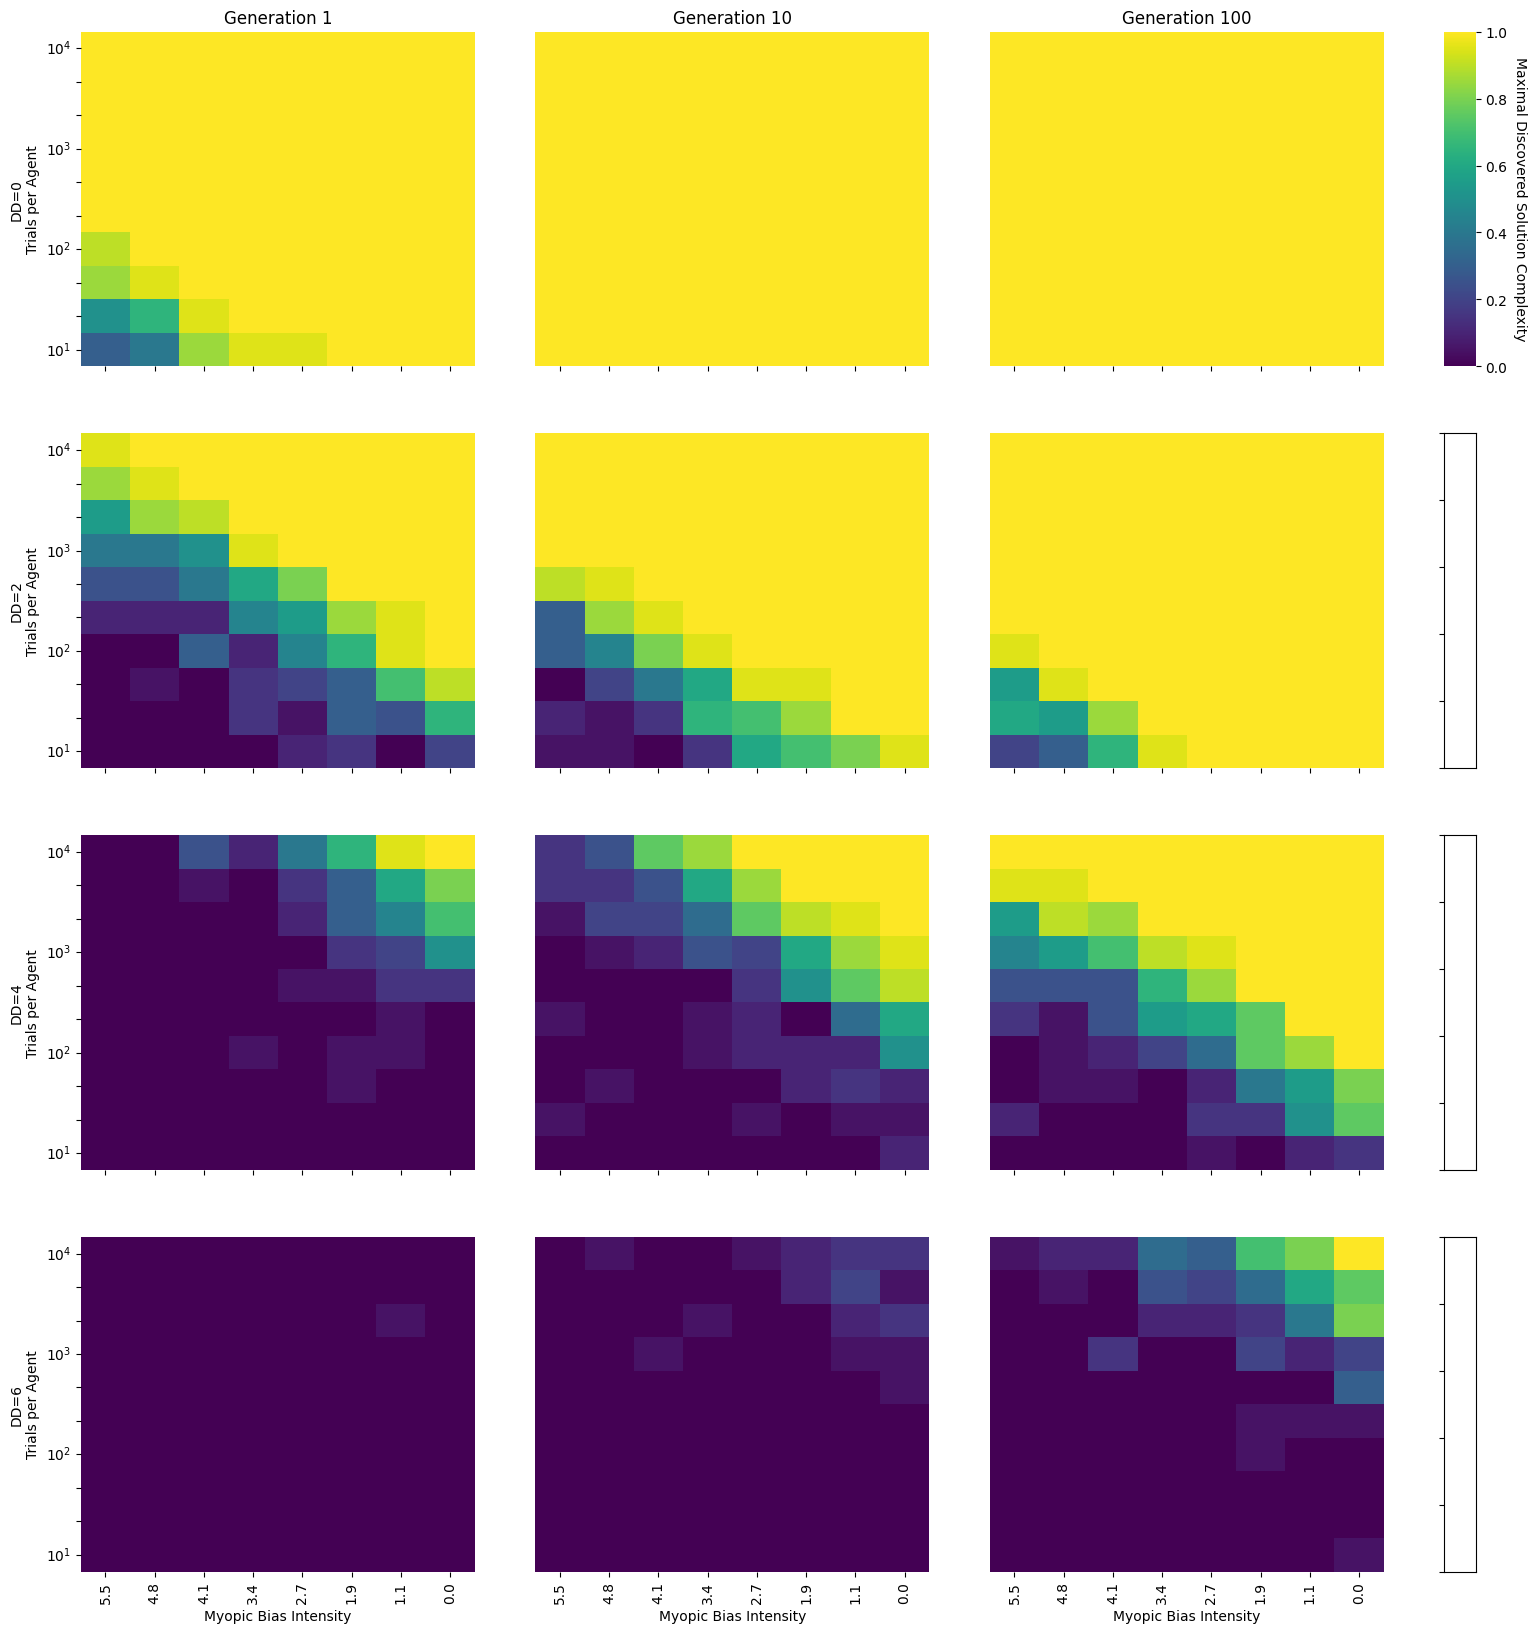

In [94]:
dd_values = [0, 2, 4, 6]

m = df_agg.reset_index().pivot_table(index=['gen', 'discoverability difficulty', 'K_human'],
                               columns='myopic bias intensity', values='discovered')

import matplotlib.pyplot as plt

m = m.sort_index(axis=0, ascending=False)
m = m.sort_index(axis=1, ascending=False)

generations = [0, 9, 99]

# Create a 4x4 grid: 4 rows (one for each dd_value) and 4 columns (3 for generations + 1 for colorbar)
fig, axs = plt.subplots(len(dd_values), 4, figsize=(18, 5*len(dd_values)), 
                        gridspec_kw={"width_ratios": [1, 1, 1, 0.08]})

# Loop through dd_values (rows) and generations (columns)
for row_idx, dd_val in enumerate(dd_values):
    for col_idx, gen in enumerate(generations):
        # Access data using MultiIndex: (gen, dd_value)
        data = m.loc[(gen, dd_val)]
        ax = axs[row_idx, col_idx]
        
        # Create heatmap
        hm = sns.heatmap(data, ax=ax, cbar=False, cmap='viridis', vmin=0, vmax=1)
        
        # Set labels
        if col_idx == 0:
            ax.set_ylabel(f'DD={dd_val}\nTrials per Agent')
            # Format the y-ticks (one significant digit)
            yvals = data.index.values
            mask = np.isclose(np.log10(yvals) % 1, 0)
            ax.set_yticklabels([rf"$10^{int(np.log10(v))}$" if mask_val else '' for v,mask_val in zip(yvals, mask)])
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        
        if row_idx == len(dd_values) - 1:
            ax.set_xlabel('Myopic Bias Intensity')
            # Format the x-ticks (one significant digit)
            tick_labels = [f"{x:.1f}" for x in m.columns]
            ax.set_xticklabels(tick_labels)
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
        # Set titles
        if row_idx == 0:
            ax.set_title(f'Generation {gen+1}')

# Put the colorbar in the rightmost column
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[0, 3])
# Remove border around the colorbar
cbar.outline.set_visible(False)
# Set new label for the colorbar
cbar.ax.set_ylabel('Maximal Discovered Solution Complexity', rotation=-90, va="bottom")

# Hide ticks and labels on the colorbar axes except for the first one
for row_idx in range(1, len(dd_values)):
    axs[row_idx, 3].set_yticklabels([])
    axs[row_idx, 3].set_xticks([])
axs[0, 3].set_xticks([])


In [ ]:
df_ = df_agg.reset_index()

In [80]:
df_.groupby(['gen', 'K_human', 'myopic bias intensity', 'discoverability difficulty']).mean()

rep  \
gen K_human myopic bias intensity discoverability difficulty            
0   10      0.000000              -0.000000                     830.0   
                                   0.666667                    2430.0   
                                   1.333333                    4030.0   
                                   2.000000                    5630.0   
                                   2.666667                    7230.0   
...                                                               ...   
99  10000   5.541264               3.333333                    8769.0   
                                   4.000000                   10369.0   
                                   4.666667                   11969.0   
                                   5.333333                   13569.0   
                                   6.000000                   15169.0   

                                                              replication  \
gen K_human myopic bias intensity discoverability difficulty                
0   10      0.000000              -0.000000                           9.5   
                                   0.666667                           9.5   
                                   1.333333                           9.5   
                                   2.000000                           9.5   
                                   2.666667                           9.5   
...                                                                   ...   
99  10000   5.541264               3.333333                           9.5   
                                   4.000000                           9.5   
                                   4.666667                           9.5   
                                   5.333333                           9.5   
                                   6.000000                           9.5   

                                                              discovered  \
gen K_human myopic bias intensity discoverability difficulty               
0   10      0.000000              -0.000000                         1.00   
                                   0.666667                         1.00   
                                   1.333333                         1.00   
                                   2.000000                         0.20   
                                   2.666667                         0.10   
...                                                                  ...   
99  10000   5.541264               3.333333                         1.00   
                                   4.000000                         1.00   
                                   4.666667                         0.40   
                                   5.333333                         0.10   
                                   6.000000                         0.05   

                                                              optimal  myopic  \
gen K_human myopic bias intensity discoverability difficulty                    
0   10      0.000000              -0.000000                    9.9375  0.0625   
                                   0.666667                    6.7500  3.2500   
                                   1.333333                    2.9375  7.0625   
                                   2.000000                    0.2500  9.7500   
                                   2.666667                    0.1250  9.8750   
...                                                               ...     ...   
99  10000   5.541264               3.333333                    9.0000  1.0000   
                                   4.000000                    9.1250  0.8750   
                                   4.666667                    3.3125  6.6875   
                                   5.333333                    1.0000  9.0000   
                                   6.000000                    0.5000  9.5000   

                                                              other  \


In [81]:
df_['discovered'] = df_['discovered'].astype(float)

In [82]:
df_['myopic bias intensity'].unique()

array([5.54126355, 4.84418709, 4.14313473, 3.4339872 , 2.7080502 ,
       1.94591015, 1.09861229, 0.        ])

In [83]:
df_['discoverability difficulty'].unique()

array([-0.        ,  0.66666667,  1.33333333,  2.        ,  2.66666667,
        3.33333333,  4.        ,  4.66666667,  5.33333333,  6.        ])

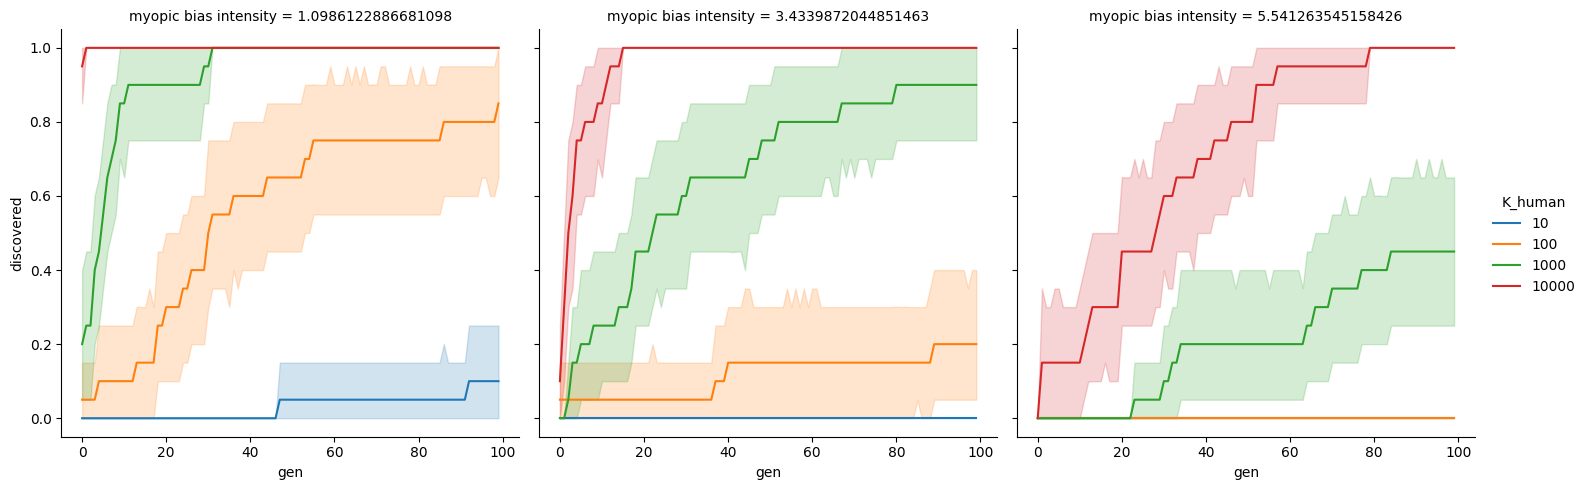

In [84]:
w = (
    df_['myopic bias intensity'].isin(df_['myopic bias intensity'].unique()[::3])
    & df_['K_human'].isin(df_['K_human'].unique()[::3]) 
    & df_['discoverability difficulty'].isin([4])
)

df_['K_human'] = df_['K_human'].astype(str)

sns.relplot(
    data=df_[w], x='gen', 
    y='discovered', 
    hue='K_human', 
    col='myopic bias intensity', 
    kind='line')

In [85]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# How does exploration horizon and bias discover rate of optimal solution

N_gen = 8  # Number of agents per generation
N_mach = 0  # Number of machines
G = 10
K_demo = 10

K_human_log = np.linspace(0, 3, 10)
K_human = [10]
K_machine = [1000]

q_opt_human = [0.01]
q_opt_machine = [0.5]

epsilon = [1] # Success in demonstration learned solution
R = 10  # Number of replications of the simulation
n_teacher = [1, 5] # Number of agents observed during social learning

d_myopic = [0.5]  # Discoverability rate for myopic solutions
d_optimal_log_ = np.linspace(0, -6, 10)
# d_optimal_log_ = [-4.]

lambda_ = np.linspace(0.0, 0.35, 36)  # Social learning rate
conditions = ['human', 'human-machine']


grid_d = {
    'condition': conditions,
    'd_myopic': d_myopic,
    'd_optimal_log': d_optimal_log_,
    'lambda': lambda_,
    'n_teacher': n_teacher,
    'replication': np.arange(R),
    'epsilon': epsilon,
    'q_opt_human': q_opt_human,
    'K_human': K_human,
    'K_machine': K_machine,
    'q_opt_machine': q_opt_machine,
}

d = grid_dict(grid_d)
df = run_simulation(d, G, N_gen, N_mach, K_demo)

df['K_human'] = df['K_human'].astype(str)


0
